In [1]:
import os
import sys
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(notebook_dir)

if project_dir not in sys.path:
    sys.path.append(project_dir)

import pandas as pd
import numpy as np

In [2]:
all_fighter_cluster = pd.read_csv(r"https://raw.githubusercontent.com/john-adeojo/ufc_styles/main/data/02_intermediate/all_fighter_clusters.csv")
fighter_data = pd.read_csv(r"https://github.com/john-adeojo/ufc_styles/blob/main/data/02_intermediate/fighter_data.csv?raw=true")
all_fighter_cluster = all_fighter_cluster.loc[all_fighter_cluster['cluster'] != -1]

In [3]:
analysis_data_base = fighter_data.merge(right=all_fighter_cluster[['cluster','specific_cluster', 'Fighter_dims', 'weight_class']], how='left', left_on=['Fighter_dims', 'weight_class'], right_on=['Fighter_dims', 'weight_class'])
analysis_data_base = analysis_data_base.dropna(subset=['cluster'])
analysis_data_opp = analysis_data_base.copy()
analysis_data_opp['opp_specific_cluster'] = analysis_data_opp['specific_cluster']
analysis_data = analysis_data_base.merge(right=analysis_data_opp[['weight_class', 'Fighter_dims', 'date', 'opp_specific_cluster']], how='inner', left_on=['weight_class', 'Opponent', 'date'], right_on=['weight_class', 'Fighter_dims', 'date'] )
analysis_data_opposing_styles = analysis_data.loc[analysis_data['opp_specific_cluster'] != analysis_data['specific_cluster']].copy()

In [4]:
analysis_data_opposing_styles = analysis_data_opposing_styles.loc[analysis_data_opposing_styles['corner'] == 'Red'].copy()
analysis_data_opposing_styles = analysis_data_opposing_styles.loc[analysis_data_opposing_styles['fighter_result'] != 'Loss by DQ'].copy()

In [5]:
import pandas as pd

# Assuming your DataFrame is named 'analysis_data_opposing_styles'
# and the columns to combine are 'specific_cluster' and 'opp_specific_cluster'

def create_style_matchup(row):
    # Combine the two columns and sort them alphabetically
    matchup = sorted([row['specific_cluster'], row['opp_specific_cluster']])
    
    # Join them with ' vs. ' and return the result
    return matchup[0] + ' vs. ' + matchup[1]

# Apply the custom function to each row and create the new 'style_matchup' column
analysis_data_opposing_styles['style_matchup'] = analysis_data_opposing_styles.apply(create_style_matchup, axis=1)

# Display the DataFrame
analysis_data_opposing_styles.sort_values(by='weight_class', inplace=True)


In [6]:
weight_class = list(analysis_data_opposing_styles['weight_class'].drop_duplicates())
weight_class

['Bantamweight',
 'Featherweight',
 'Flyweight',
 'Heavyweight',
 'LightHeavyweight',
 'Lightweight',
 'Middleweight',
 'Welterweight',
 'WomenFlyweight',
 'WomenStrawweight']

In [7]:
from scripts.chisquareanalysis import ChiSquareAnalysis

# Assuming weight_class is a list of weight classes

results = {}  # Initialize an empty dictionary to store the results

for weights in weight_class:
    analysis = ChiSquareAnalysis(df=analysis_data_opposing_styles, weight_class=weights)
    result, significant_weight_class = analysis.run_chisquare_analysis('fighter_result')
    if not isinstance(result, str):
        results[significant_weight_class] = result  # Save the result in the dictionary with the key as the weight class
    

Bantamweight
Chi2 Stat: 0.0
P Value: 1.0
Degrees of Freedom: 0
Featherweight
Chi2 Stat: 1231.6507350468141
P Value: 2.3942539676366714e-252
Degrees of Freedom: 16
Flyweight
Chi2 Stat: 1075.9799712117874
P Value: 3.108442899626613e-203
Degrees of Freedom: 35
Heavyweight
Chi2 Stat: 0.0
P Value: 1.0
Degrees of Freedom: 0
LightHeavyweight
Chi2 Stat: 0.0
P Value: 1.0
Degrees of Freedom: 0
Lightweight
Chi2 Stat: 3436.662305607523
P Value: 0.0
Degrees of Freedom: 20
Middleweight
Chi2 Stat: 1374.3375188011287
P Value: 3.5149928067210887e-279
Degrees of Freedom: 20
Welterweight
Chi2 Stat: 4334.2319191980605
P Value: 0.0
Degrees of Freedom: 22
WomenFlyweight
Chi2 Stat: 352.1240243279552
P Value: 1.475266390497426e-66
Degrees of Freedom: 14
WomenStrawweight
Chi2 Stat: 0.0
P Value: 1.0
Degrees of Freedom: 0


In [8]:
significant_weight_classes = list(results.keys())
significant_weight_classes

['Featherweight',
 'Flyweight',
 'Lightweight',
 'Middleweight',
 'Welterweight',
 'WomenFlyweight']

In [9]:
fighter_result = list(analysis_data_opposing_styles['fighter_result'].drop_duplicates())

In [10]:
standard_residuals = {}  # Initialize an empty dictionary to store the results

for weights in significant_weight_classes:
    standard_residuals[weights] = results[weights]  # Save the result in the dictionary with the key as the weight class


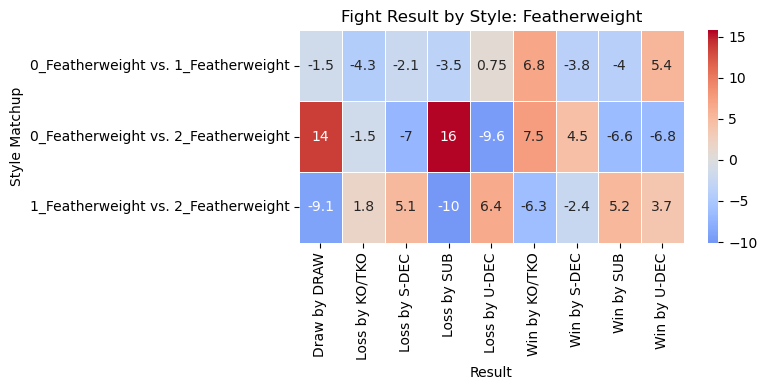

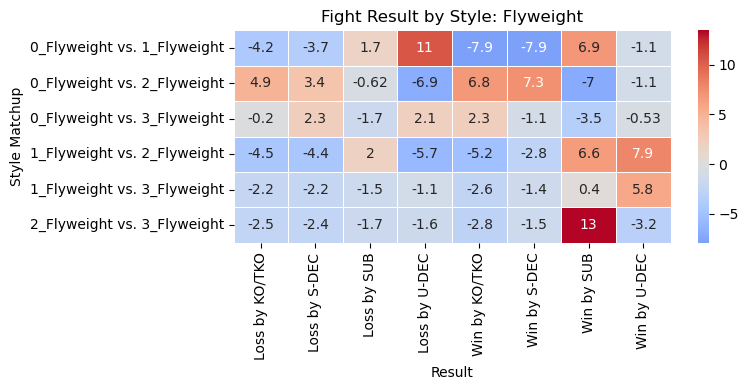

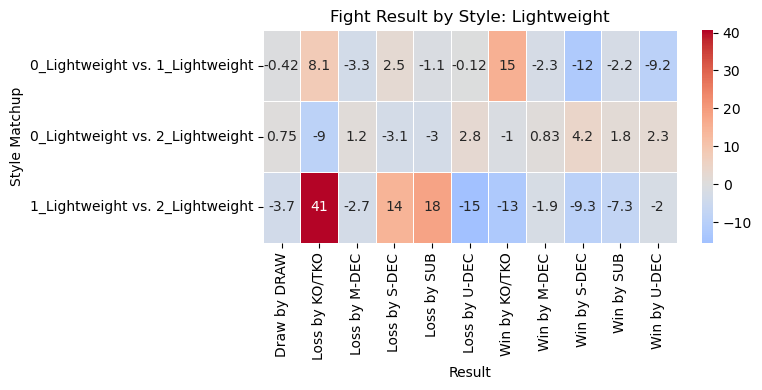

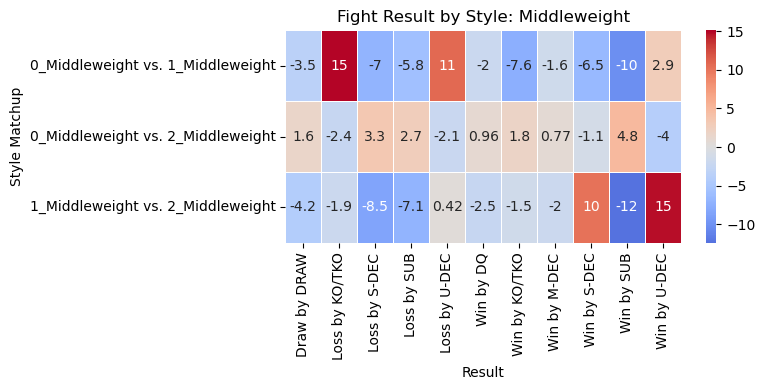

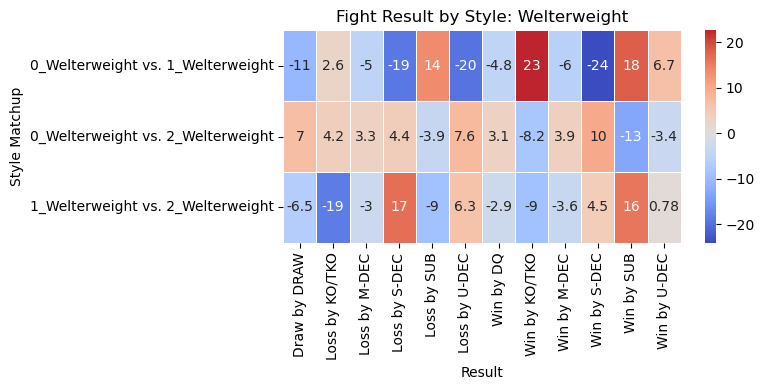

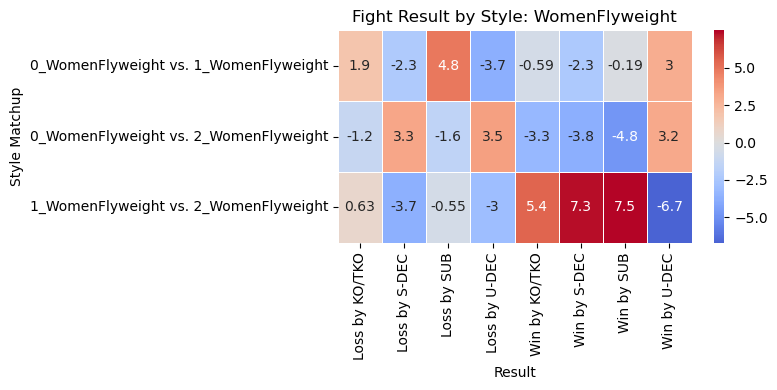

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(standard_residuals, weight_class):
    col = standard_residuals.drop(columns=['style_matchup']).columns
    # Prepare the data for the heatmap
    heatmap_data = standard_residuals.set_index('style_matchup')[col]
    # Create the heatmap
    plt.figure(figsize=(8, 4))
    sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, linewidths=0.5, center=0)
    plt.title(f'Fight Result by Style: {weight_class}')
    plt.xlabel('Result')
    plt.ylabel('Style Matchup')
    plt.tight_layout()  # Add this line to adjust the layout
    plt.savefig(f"C:\\Users\\johna\\anaconda3\\envs\\ufc-env\\ufc_styles\\data\\03_reports\\residuals_{weight_class}.png")
    plt.show()

    
for weights in significant_weight_classes:
    heatmap(standard_residuals=standard_residuals[weights], weight_class=weights)


In [12]:
import requests
import json
# import style dims
url = 'https://github.com/john-adeojo/ufc_styles/raw/main/data/02_intermediate/style_dims_names.json'

# Fetch the JSON file content
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:
    try:
        # Load the content into a list
        style_dims_names = json.loads(response.text)
        print("Data loaded successfully:")
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
else:
    print(f"Failed to fetch JSON file: {response.status_code}")

Data loaded successfully:


In [13]:
style_dims_names_2 = style_dims_names
style_dims_names_2.append('specific_cluster')

In [48]:
def generate_radar_data(selected_clusters):
    selected_clusters = selected_clusters
    filtered_data = analysis_data_opposing_styles[analysis_data_opposing_styles['specific_cluster'].isin(selected_clusters)]
    analytics_for_radar = filtered_data[style_dims_names_2].groupby(['specific_cluster']).median()
    analytics_for_radar.reset_index(inplace=True)
    return analytics_for_radar

radar_chart_data = {}
for weights in significant_weight_classes:
    selected_clusters = list(all_fighter_cluster.loc[all_fighter_cluster['weight_class'] == weights]['specific_cluster'].drop_duplicates())
    radar_chart_data[weights] = generate_radar_data(selected_clusters)
    

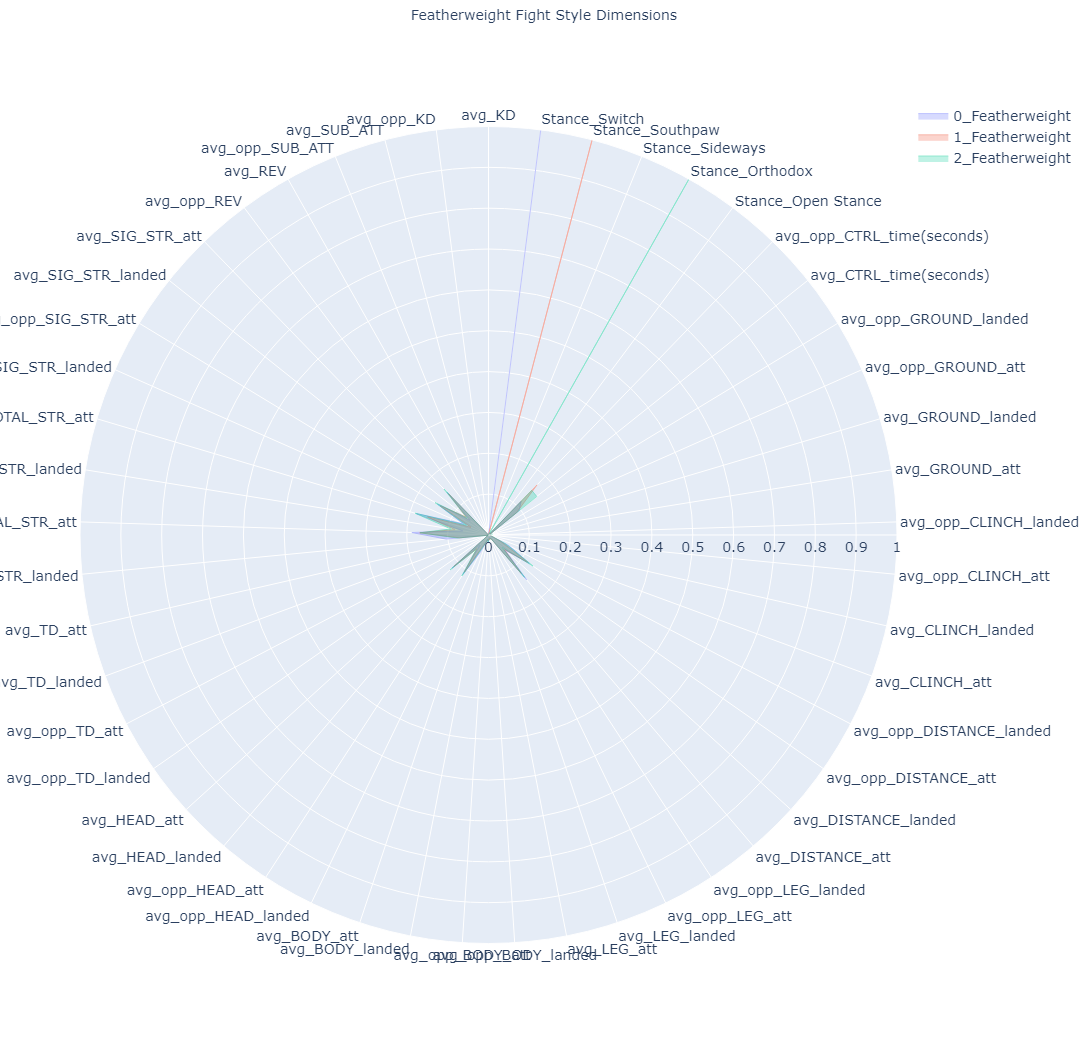

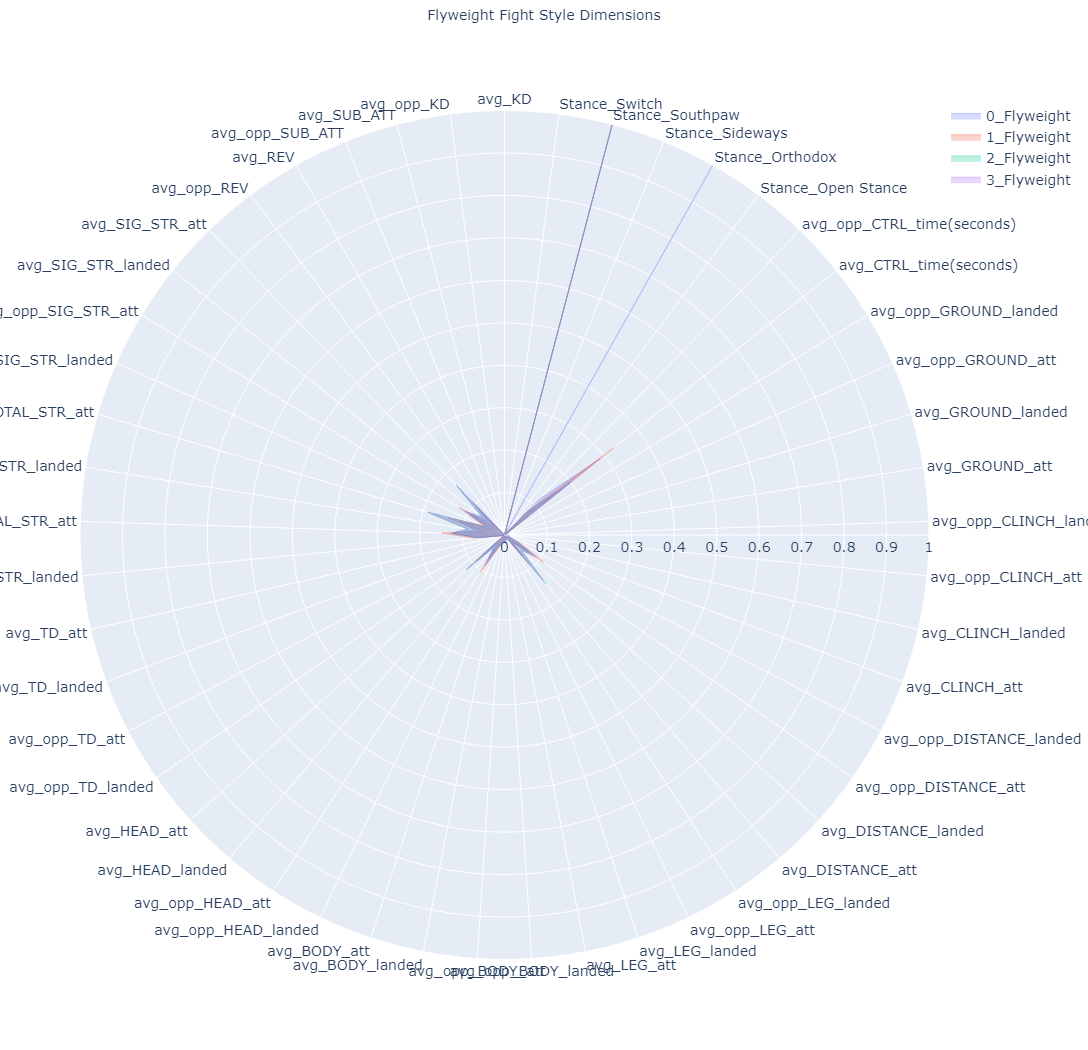

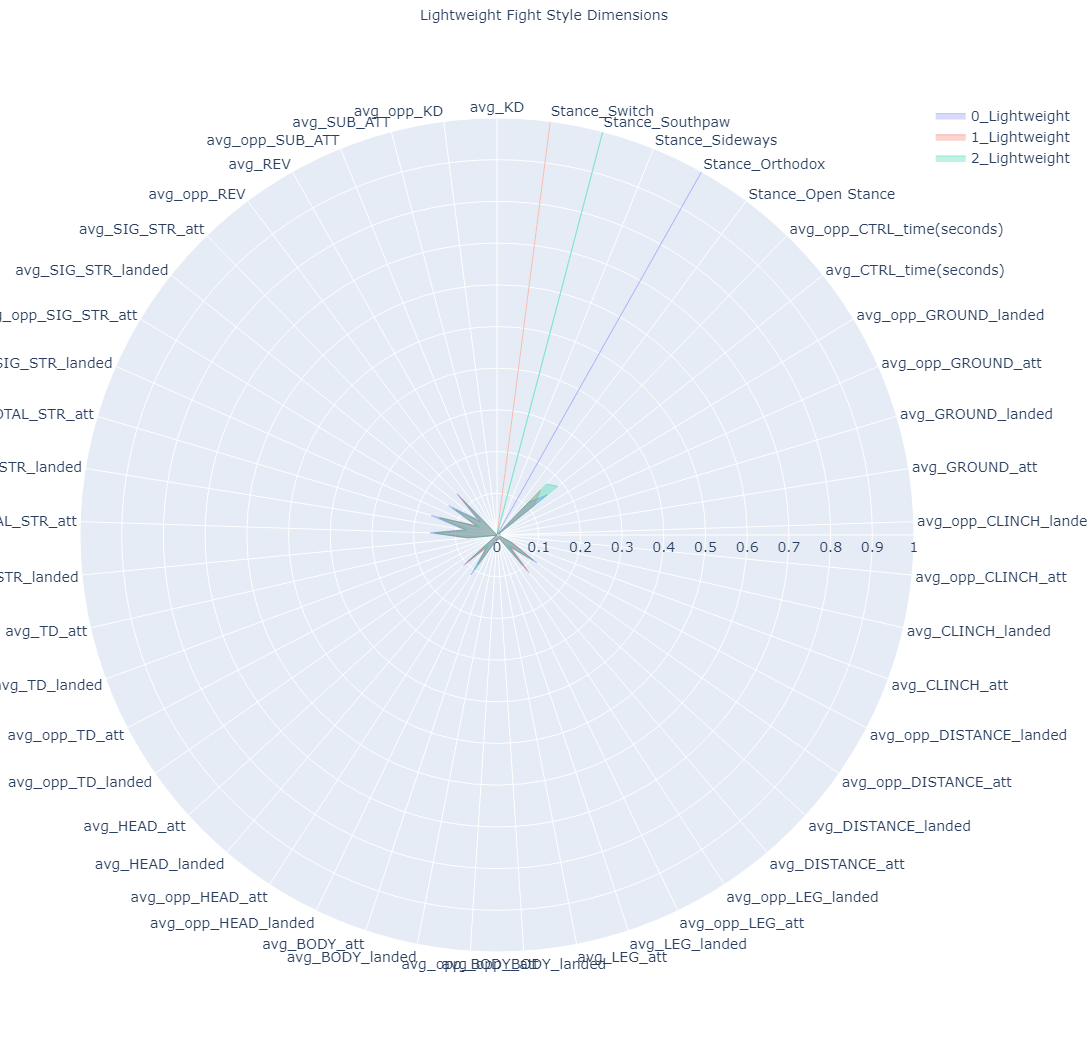

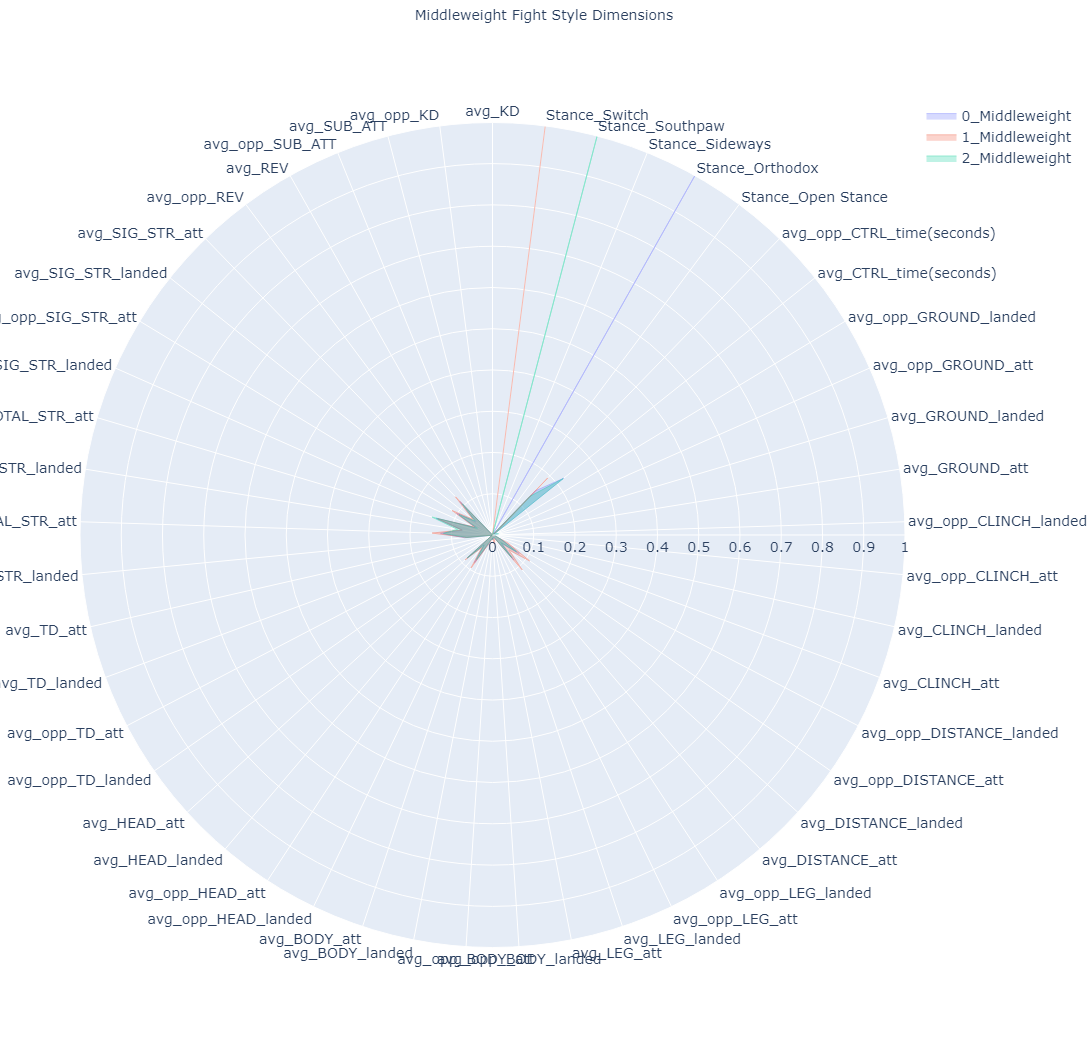

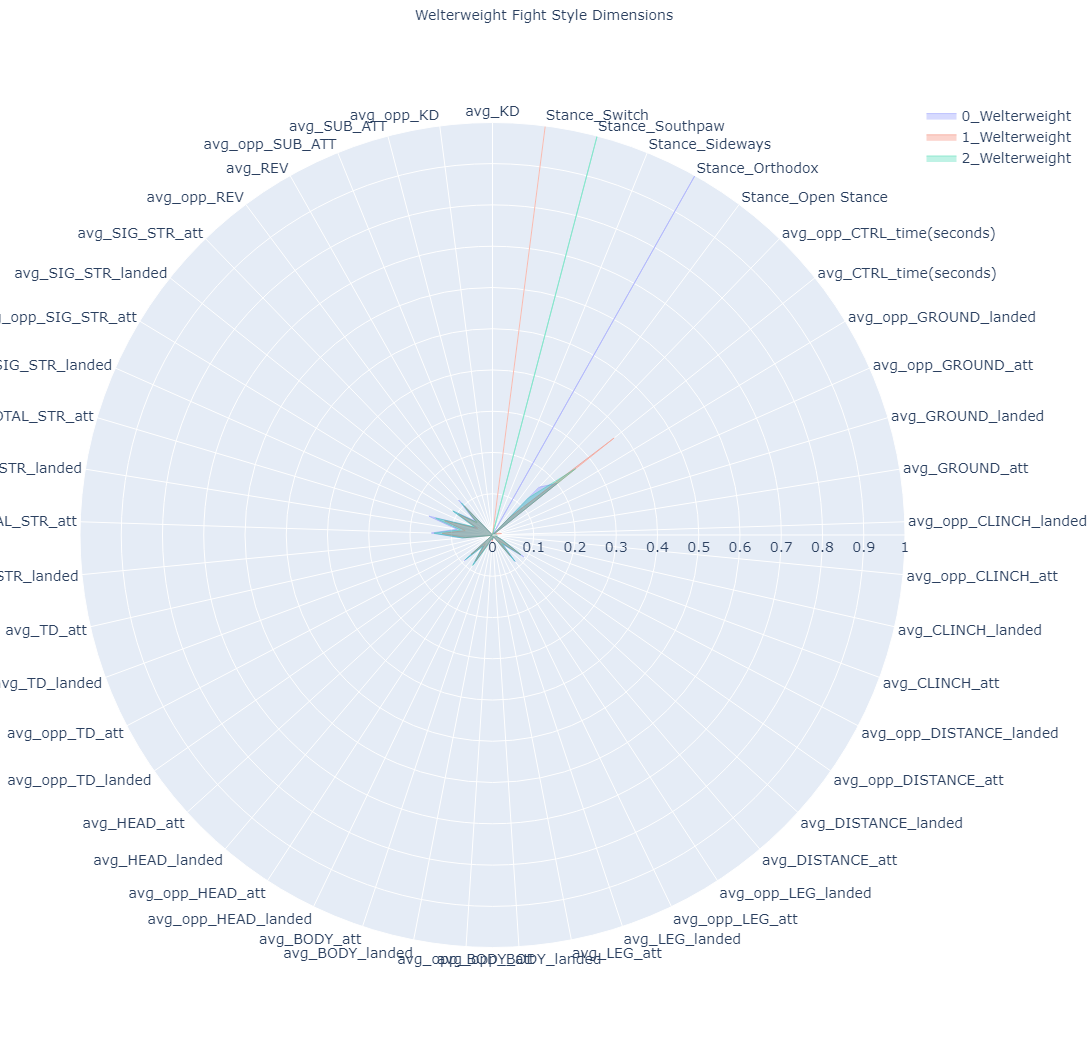

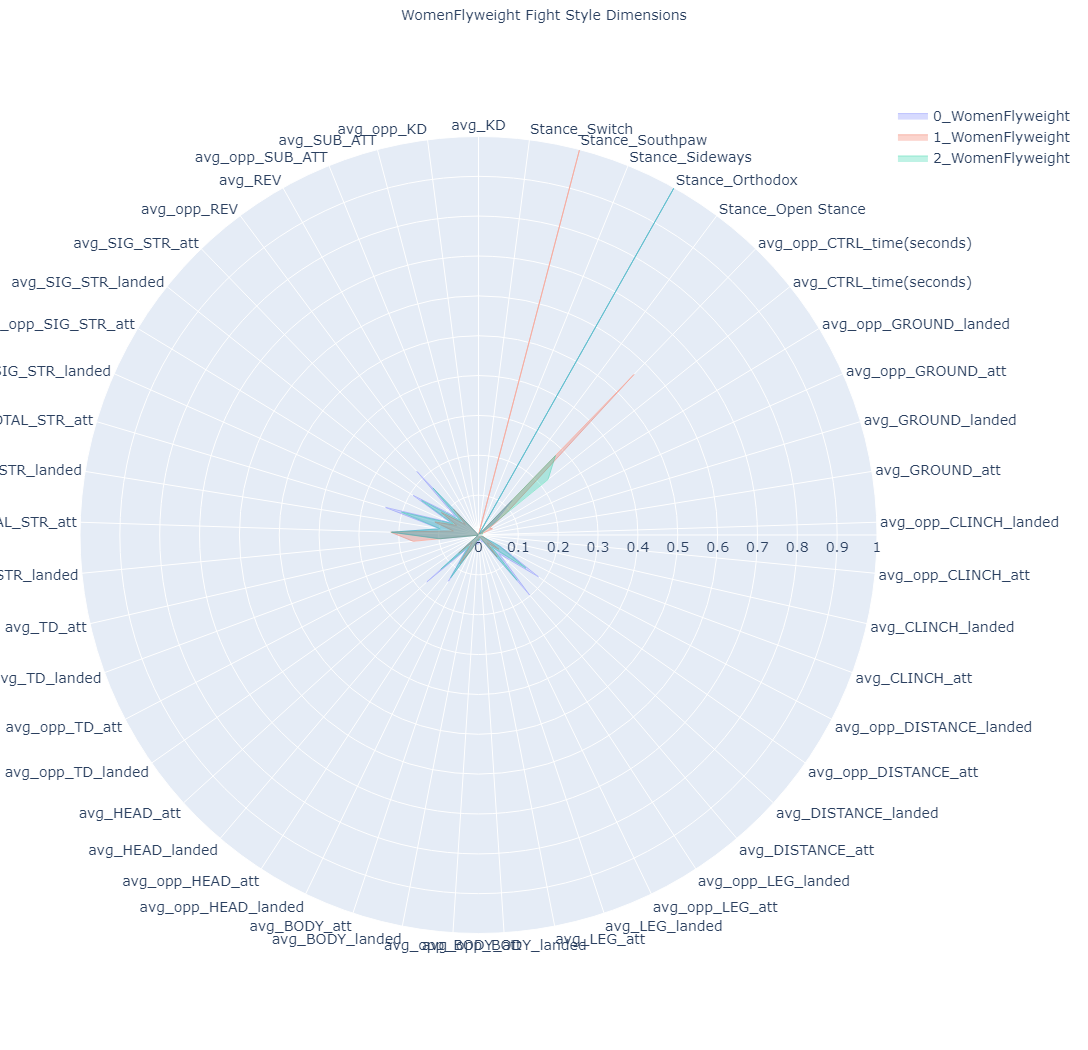

In [49]:
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

def plot_fighters_radar_chart(data, weight_class, save_path):
    dimensions = data.drop(columns='specific_cluster').columns
    fig = go.Figure()

    for specific_cluster in data['specific_cluster'].unique():
        cluster_data = data[data['specific_cluster'] == specific_cluster]

        fig.add_trace(go.Scatterpolar(
            r=cluster_data[dimensions].values.tolist()[0],
            theta=dimensions,
            fill='toself',
            name=specific_cluster,
            opacity=0.5,
            line=dict(width=0.8)
        ))

    fig.update_layout(
        title=dict(
            text=f'{weight_class} Fight Style Dimensions',
            x=0.5,
            y=0.99,
            font=dict(size=14)
        ),

        
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, data[dimensions].values.astype(float).max()],
                tickfont=dict(size=14)  # Increase tick font size
            ),
            angularaxis=dict(
                rotation=90,
                direction="counterclockwise",
                tickfont=dict(size=14)  # Increase tick font size
            ),
        ),
        showlegend=True,
        width=1450,
        height=1050,
        legend=dict(font=dict(size=14))  # Increase legend font size
    )

    pio.write_image(fig, save_path)
    fig.show()

# Replace `significant_weight_classes` with the actual list of weight classes
for weights in significant_weight_classes:
    save_path = f"C:\\Users\\johna\\anaconda3\\envs\\ufc-env\\ufc_styles\\data\\03_reports\\radar_plots_{weights}.png"
    plot_fighters_radar_chart(data=radar_chart_data[weights], weight_class=weights, save_path=save_path)


In [46]:
radar_chart_data['Middleweight']

,specific_cluster,avg_KD,avg_opp_KD,avg_SUB_ATT,avg_opp_SUB_ATT,avg_REV,avg_opp_REV,avg_SIG_STR_att,avg_SIG_STR_landed,avg_opp_SIG_STR_att,...,avg_GROUND_landed,avg_opp_GROUND_att,avg_opp_GROUND_landed,avg_CTRL_time(seconds),avg_opp_CTRL_time(seconds),Stance_Open Stance,Stance_Orthodox,Stance_Sideways,Stance_Southpaw,Stance_Switch
0,0_Middleweight,-0.185810,-0.277132,-0.322213,-0.281154,-0.41177,-0.421126,-0.346476,-0.243789,-0.387643,...,-0.188580,-0.262995,-0.258181,-0.103112,-0.105801,0.0,1.0,0.0,0.0,0.0
1,1_Middleweight,-0.012364,-0.283201,-0.468325,-0.444986,-0.41177,-0.421126,0.064012,0.092417,0.049289,...,-0.342026,-0.513814,-0.507154,-1.061558,-0.194180,0.0,0.0,0.0,0.0,1.0
2,2_Middleweight,-0.148020,-0.282427,-0.387492,-0.409988,-0.41177,-0.421126,-0.377029,-0.257640,-0.424096,...,-0.132133,-0.328547,-0.322100,-0.172394,-0.426440,0.0,0.0,0.0,1.0,0.0


In [47]:
analysis_data_opposing_styles

,R_fighter,B_fighter,date,Winner,weight_class,avg_KD,avg_opp_KD,avg_SUB_ATT,avg_opp_SUB_ATT,avg_REV,...,Stance_Switch,Stance_nan,fighter,method,fighter_result,cluster,specific_cluster,Fighter_dims_y,opp_specific_cluster,style_matchup
568452,Raphael Assuncao,Cory Sandhagen,2019-08-17,Blue,Bantamweight,0.000239,0.000954,0.000006,0.000973,0.000000,...,0.0,0.0,Raphael Assuncao,U-DEC,Loss by U-DEC,1.0,1_Bantamweight,Cory Sandhagen,0_Bantamweight,0_Bantamweight vs. 1_Bantamweight
736861,Hugo Viana,Guido Cannetti,2015-08-01,Blue,Bantamweight,0.000588,0.000168,0.000000,0.000000,0.000000,...,0.0,0.0,Hugo Viana,U-DEC,Loss by U-DEC,1.0,1_Bantamweight,Guido Cannetti,0_Bantamweight,0_Bantamweight vs. 1_Bantamweight
736862,Hugo Viana,Guido Cannetti,2015-08-01,Blue,Bantamweight,0.000588,0.000168,0.000000,0.000000,0.000000,...,0.0,0.0,Hugo Viana,U-DEC,Loss by U-DEC,1.0,1_Bantamweight,Guido Cannetti,0_Bantamweight,0_Bantamweight vs. 1_Bantamweight
736863,Hugo Viana,Guido Cannetti,2015-08-01,Blue,Bantamweight,0.000588,0.000168,0.000000,0.000000,0.000000,...,0.0,0.0,Hugo Viana,U-DEC,Loss by U-DEC,1.0,1_Bantamweight,Guido Cannetti,0_Bantamweight,0_Bantamweight vs. 1_Bantamweight
736864,Hugo Viana,Guido Cannetti,2015-08-01,Blue,Bantamweight,0.000588,0.000168,0.000000,0.000000,0.000000,...,0.0,0.0,Hugo Viana,U-DEC,Loss by U-DEC,1.0,1_Bantamweight,Guido Cannetti,0_Bantamweight,0_Bantamweight vs. 1_Bantamweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725989,Seo Hee Ham,Cortney Casey,2015-11-28,Red,WomenStrawweight,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,Seo Hee Ham,U-DEC,Win by U-DEC,1.0,1_WomenStrawweight,Cortney Casey,0_WomenStrawweight,0_WomenStrawweight vs. 1_WomenStrawweight
725988,Seo Hee Ham,Cortney Casey,2015-11-28,Red,WomenStrawweight,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,Seo Hee Ham,U-DEC,Win by U-DEC,1.0,1_WomenStrawweight,Cortney Casey,0_WomenStrawweight,0_WomenStrawweight vs. 1_WomenStrawweight
725987,Seo Hee Ham,Cortney Casey,2015-11-28,Red,WomenStrawweight,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,Seo Hee Ham,U-DEC,Win by U-DEC,1.0,1_WomenStrawweight,Cortney Casey,0_WomenStrawweight,0_WomenStrawweight vs. 1_WomenStrawweight
725985,Seo Hee Ham,Cortney Casey,2015-11-28,Red,WomenStrawweight,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,Seo Hee Ham,U-DEC,Win by U-DEC,1.0,1_WomenStrawweight,Cortney Casey,0_WomenStrawweight,0_WomenStrawweight vs. 1_WomenStrawweight
